In [2]:
import numpy as np
import matplotlib.pyplot as plt

from rough_bergomi.models import RoughBergomiModel, GBMModel, HestonModel
from rough_bergomi.utils.utils import bs_delta, bsinv, bs  # Black-Scholes inversion for IV calculation
import seaborn as sns
import yfinance as yf

from rough_bergomi.hedging.deep_hedger import DeepHedgerTF
from rough_bergomi.utils.plotting import plot_paths 

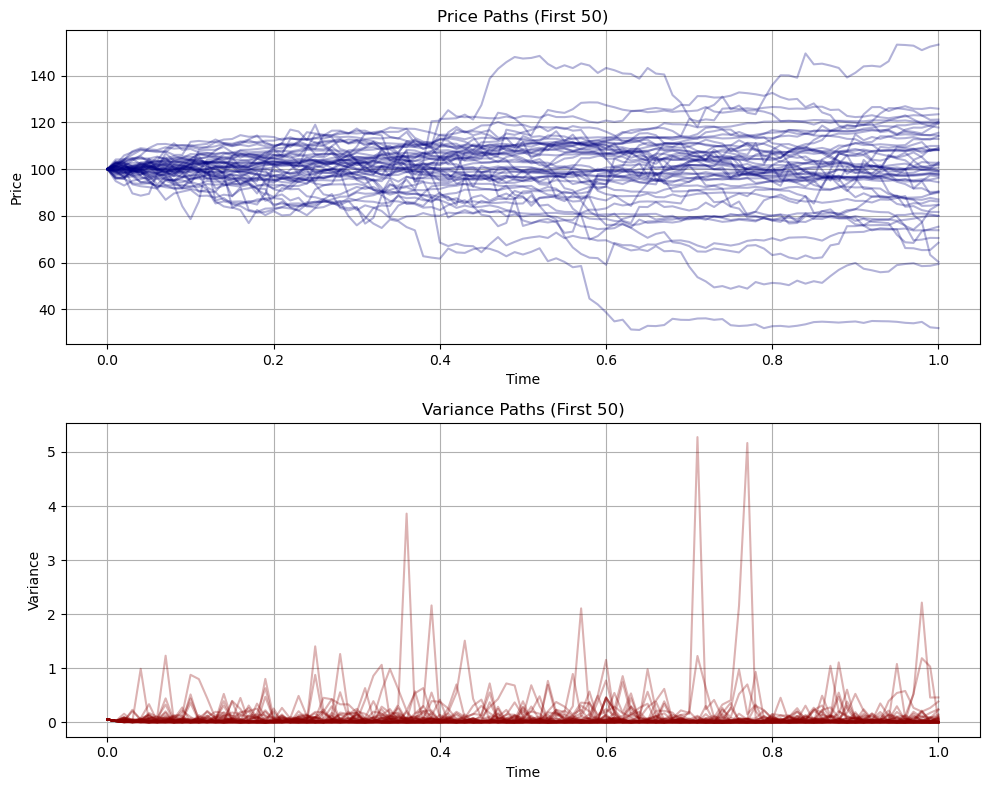

In [4]:
# Simulation parameters
T = 1.0
N = 100
M = 10000
S0 = 100.0

model = RoughBergomiModel(fbm_method="hybrid")
S, V = model.simulate_paths(n_paths=M, n_steps=N, T=T, S0=S0)
t = np.linspace(0, T, V.shape[1])

plot_paths(S, V, t, n_plot=50)

Calibrated ATM volatility: 0.18983806677736814


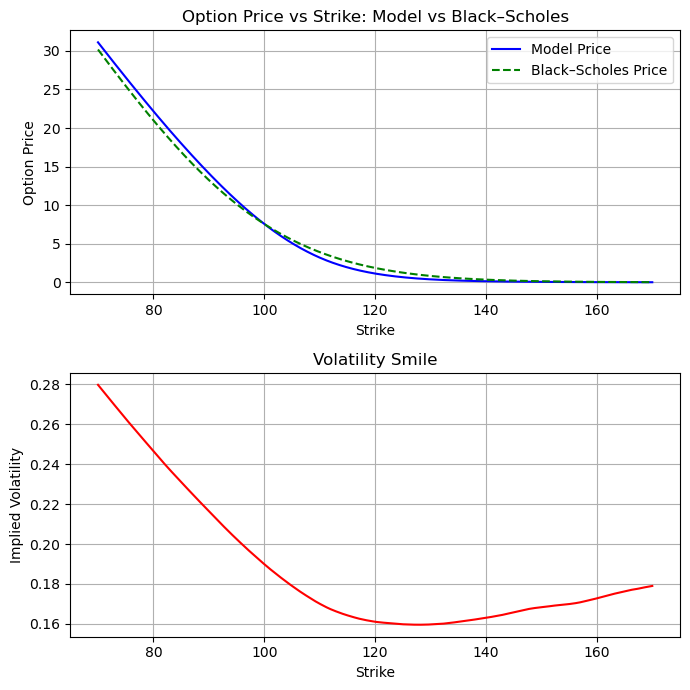

In [8]:
strikes = np.linspace(70, 170, 1000)  # Range of strike prices
r = 0
option_prices = []
implied_vols = []

# Loop over each strike to calculate option price and implied volatility
for k in strikes:
    price = model.price_european(S, k, T, r)
    option_prices.append(price)
    
    iv = bsinv(price, S0, k, T, r)
    implied_vols.append(iv)

# Calibrate the ATM volatility using the strike closest to S0
atm_index = np.argmin(np.abs(strikes - S0))
atm_strike = strikes[atm_index]
atm_price = model.price_european(S, atm_strike, T, r)
atm_vol = bsinv(atm_price, S0, atm_strike, T, 'call')
print("Calibrated ATM volatility:", atm_vol)

# Compute Black–Scholes prices using a constant volatility (e.g., 20% annualized)
vol = atm_vol
bs_prices = []
for k in strikes:
    # Integrated variance V = sigma^2 * T
    bs_price = bs(S0, k, vol**2 * T, o='call')
    bs_prices.append(bs_price)

# Plotting
plt.figure(figsize=(7, 7))

# Plotting the results
plt.subplot(2,1,1)
plt.plot(strikes, option_prices, label='Model Price', color='blue')
plt.plot(strikes, bs_prices, label='Black–Scholes Price', color='green', linestyle='--')
plt.title('Option Price vs Strike: Model vs Black–Scholes')
plt.xlabel('Strike')
plt.ylabel('Option Price')
plt.grid(True)
plt.legend()

# Volatility smile: Implied Volatility vs. Strike
plt.subplot(2, 1, 2)
plt.plot(strikes, implied_vols, color='red')
plt.title('Volatility Smile')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.grid(True)

plt.tight_layout()
plt.show()

Mean hedging error: 0.26160269695116084
Std of hedging error: 4.407192508734305


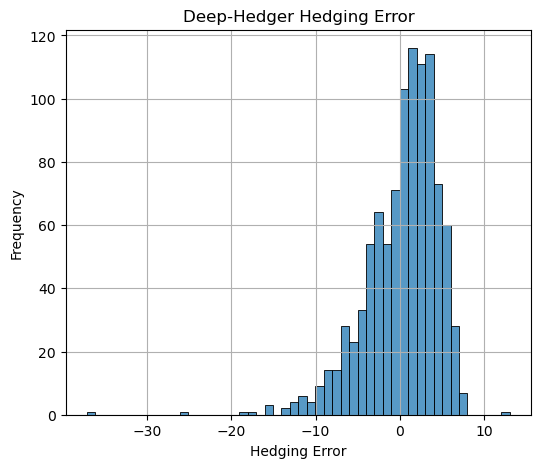

In [11]:
K = 100
dh = DeepHedgerTF(
    model=model,
    S0=S0,
    K_strike=K,
    M=1000,
    T=T,
    N=N,
    r=0.0,
    CALL=True
)

dh.prepare_data()
dh.build_and_compile_model(lr=0.005, loss_type='entropic')
dh.train_model(batch_size=256, epochs=50)

error = dh.evaluate_model()
dh.plot_error()